# Exploratory data analysis
In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. For homework, you will work on this entire notebook for your own targets. Download your target related data from the following databases:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/

## Install packages

In [1]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

TensorFlow 1.x selected.
--2021-03-19 14:37:28--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M  3.62MB/s    in 2m 3s   

2021-03-19 14:39:32 (4.10 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-nav

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-forge
    bravado-core-5.17.0        |     pyh9f0a

In [4]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import io

In [5]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

## Download/Load data

In [13]:
! wget https://raw.githubusercontent.com/ZhenZhangz/E4511/main/ExCAPE_SLC6A4.csv
! wget https://raw.githubusercontent.com/ZhenZhangz/E4511/main/chEMBL_SLC6A4.csv
! wget https://raw.githubusercontent.com/ZhenZhangz/E4511/main/DTC_SLC6A4.csv

--2021-03-19 14:54:42--  https://raw.githubusercontent.com/ZhenZhangz/E4511/main/ExCAPE_SLC6A4.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1077836 (1.0M) [text/plain]
Saving to: ‘ExCAPE_SLC6A4.csv’

ExCAPE_SLC6A4.csv   100%[===================>]   1.03M  --.-KB/s    in 0.07s   

2021-03-19 14:54:43 (13.8 MB/s) - ‘ExCAPE_SLC6A4.csv’ saved [1077836/1077836]

--2021-03-19 14:54:43--  https://raw.githubusercontent.com/ZhenZhangz/E4511/main/chEMBL_SLC6A4.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5744195 (5.5M) [text/p

In [27]:
dtc = pd.read_csv("DTC_SLC6A4.csv", sep=',', header=0 )
excape = pd.read_csv("ExCAPE_SLC6A4.csv", sep=',', header=0)
chembl = pd.read_csv("chEMBL_SLC6A4.csv", sep=';', header=0)

In [16]:
dtc.iloc[1:3,1:10] # row 1-2 column 1-9 

,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id
1,AAADQEFQWNJHOZ-UHFFFAOYSA-N,NaN,NaN,P31645,SEROTONIN TRANSPORTER,SLC6A4,NaN,NaN,12213053.0
2,AAEKULYONKUBOZ-UHFFFAOYSA-N,NaN,NaN,P31645,SEROTONIN TRANSPORTER,SLC6A4,NaN,NaN,14971892.0


In [17]:
excape.iloc[1:3, 1:15]

,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
1,71541095,6532,A,6.85387,pubchem,727355,9606,SLC6A4,4061,ClC=1C=C(C2CCCCNC2)C=CC1Cl
2,CHEMBL1289,6532,A,6.37000,chembl20,774720,9606,SLC6A4,4061,C(#CI)COC=1C=C(Cl)C(=CC1Cl)Cl


In [28]:
chembl.iloc[1:3, 1:10]

,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation
1,NaN,0,388.56,1,5.44,28,Cc1cccc(C)c1N1CCN(CCCCOc2ccc3ccccc3c2)CC1,Inhibition,'='
2,NaN,0,378.49,0,4.96,31,Fc1ccc(N2CCN(CCCCOc3ccc4ccccc4c3)CC2)cc1,IC50,'='


# Examine data
- What molecular (and other) identifiers exist for compounds from each database?
- What assay response types are there in each file?
- Think about how we might combine these data sources together

In [29]:
chembl.columns = chembl.columns.str.replace(' ','_') # get rid of annoying spaces
dtc.columns = dtc.columns.str.replace(' ','_') # get rid of annoying spaces
excape.columns = excape.columns.str.replace(' ','_') # get rid of annoying spaces


print(chembl.shape)
print(dtc.shape)
print(excape.shape)

(10078, 45)
(9208, 33)
(7610, 11)


In [30]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL3310483,NaN,0,340.23,0,4.86,2aq,Fc1cc(C(CC2CNC2)Oc2cccc(Cl)c2)ccc1Cl,Inhibition,'=',100.00,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3364216,Inhibition of serotonin reuptake at human SERT...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL3352322,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3307715,NaN
1,CHEMBL4284347,NaN,0,388.56,1,5.44,28,Cc1cccc(C)c1N1CCN(CCCCOc2ccc3ccccc3c2)CC1,Inhibition,'=',38.30,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4276208,Inhibition of [3H]serotonin uptake at human SE...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4270660,1,Scientific Literature,Bioorg Med Chem,2018.0,None,NaN
2,CHEMBL4282796,NaN,0,378.49,0,4.96,31,Fc1ccc(N2CCN(CCCCOc3ccc4ccccc4c3)CC2)cc1,IC50,'=',3150.00,nM,5.50,NaN,NaN,UO_0000065,14.54,0.27,0.54,35.02,False,CHEMBL4276203,Inhibition of [3H]serotonin uptake at human SE...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4270660,1,Scientific Literature,Bioorg Med Chem,2018.0,None,NaN
3,CHEMBL4539943,NaN,0,505.57,1,3.60,None,O=C(c1ccc(OCCC2CCOCC2)cc1)[C@@H]1CC[C@H](Cn2nn...,Inhibition,'=',10.18,%,NaN,NaN,Not Active,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4507817,GPCRScan assay: inhibition of SERT,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,Parental cells: stable HEK | PMID: 3475452/200...,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4507264,54,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,None,Compound concentration None 10.0 uM
4,CHEMBL246873,NaN,0,385.94,0,4.22,12b,Clc1ccc(C2CNCc3cc(OCCCN4CCCCC4)ncc32)cc1,Ki,'=',141.00,nM,6.85,NaN,NaN,UO_0000065,17.75,0.35,2.63,18.32,False,CHEMBL886655,Binding affinity to human SERT,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1139156,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2007.0,None,NaN


In [31]:
chembl.Standard_Type.value_counts()

IC50                                                   4365
Ki                                                     4000
Inhibition                                              985
Activity                                                166
EC50                                                    161
Ratio                                                   112
FC                                                       62
pKD                                                      56
T1/2                                                     30
Kd                                                       23
ED50                                                     20
RFU                                                      20
Ratio IC50                                               16
INH                                                      11
IC5                                                      10
% Inhibition of Control Specific Binding (Mean n=2)       8
% Ctrl                                  

## Exercise: Explore datasets
- explore the loaded dtc and excape dataframes
- answer the following questions

## Questions

Number of data points in each file:

Molecular identifiers from each file:

Data types from each file:

Data units in each file:

What is the formula to translate IC50 to pIC50?

What other information might be useful?

In [ ]:
# You code goes in here and the following chunks

In [32]:
# Number of data points in each file:
print('# of data points in excape is :',len(excape))
print('# of data points in dtc is :',len(dtc))
print('# of data points in chembl is :',len(chembl))
print()
# Molecular identifiers from each file:
print('======excape===========================')
excape.info()
print('\n\n')
print('======dtc===========================')
dtc.info()
print('\n\n')
print('======chembl===========================')
chembl.info()

# of data points in excape is : 7610
# of data points in dtc is : 9208
# of data points in chembl is : 10078

======excape===========================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7610 entries, 0 to 7609
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ambit_InchiKey     7610 non-null   object 
 1   Original_Entry_ID  7610 non-null   object 
 2   Entrez_ID          7610 non-null   int64  
 3   Activity_Flag      7610 non-null   object 
 4   pXC50              7597 non-null   float64
 5   DB                 7610 non-null   object 
 6   Original_Assay_ID  7610 non-null   int64  
 7   Tax_ID             7610 non-null   int64  
 8   Gene_Symbol        7610 non-null   object 
 9   Ortholog_Group     7610 non-null   int64  
 10  SMILES             7610 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 654.1+ KB



======dtc===========================
<class 'pandas.

In [33]:
print('CHEMBL',chembl.Standard_Units.unique()) #type of variable are the data responses
print('\nDTC', dtc.standard_units.unique())

CHEMBL ['%' 'nM' nan 'hr' 'mg.kg-1' 'uM' 'ug.mL-1' 'pmol/mg']

DTC ['NM' nan '%' 'HR' 'MG.KG-1' 'UG.ML-1' 'PMOL/MG']


# EDA: assay data responses questions
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [34]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL3310483,NaN,0,340.23,0,4.86,2aq,Fc1cc(C(CC2CNC2)Oc2cccc(Cl)c2)ccc1Cl,Inhibition,'=',100.00,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3364216,Inhibition of serotonin reuptake at human SERT...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL3352322,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3307715,NaN
1,CHEMBL4284347,NaN,0,388.56,1,5.44,28,Cc1cccc(C)c1N1CCN(CCCCOc2ccc3ccccc3c2)CC1,Inhibition,'=',38.30,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4276208,Inhibition of [3H]serotonin uptake at human SE...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4270660,1,Scientific Literature,Bioorg Med Chem,2018.0,None,NaN
2,CHEMBL4282796,NaN,0,378.49,0,4.96,31,Fc1ccc(N2CCN(CCCCOc3ccc4ccccc4c3)CC2)cc1,IC50,'=',3150.00,nM,5.50,NaN,NaN,UO_0000065,14.54,0.27,0.54,35.02,False,CHEMBL4276203,Inhibition of [3H]serotonin uptake at human SE...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4270660,1,Scientific Literature,Bioorg Med Chem,2018.0,None,NaN
3,CHEMBL4539943,NaN,0,505.57,1,3.60,None,O=C(c1ccc(OCCC2CCOCC2)cc1)[C@@H]1CC[C@H](Cn2nn...,Inhibition,'=',10.18,%,NaN,NaN,Not Active,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4507817,GPCRScan assay: inhibition of SERT,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,Parental cells: stable HEK | PMID: 3475452/200...,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4507264,54,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,None,Compound concentration None 10.0 uM
4,CHEMBL246873,NaN,0,385.94,0,4.22,12b,Clc1ccc(C2CNCc3cc(OCCCN4CCCCC4)ncc32)cc1,Ki,'=',141.00,nM,6.85,NaN,NaN,UO_0000065,17.75,0.35,2.63,18.32,False,CHEMBL886655,Binding affinity to human SERT,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1139156,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2007.0,None,NaN


In [35]:
chembl.Standard_Units.unique()

array(['%', 'nM', nan, 'hr', 'mg.kg-1', 'uM', 'ug.mL-1', 'pmol/mg'],
      dtype=object)

## **Curation step**: change units to be the same for all responses

In [36]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

## EDA: Summarize, describe, plot data for analysis

In [37]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Source_ID,Document_Year,Standard_Value_nM
count,10078.000000,8.071000e+03,5888.000000,5744.000000,10078.000000,8183.000000,8.071000e+03
mean,0.695773,4.165314e+09,7.124253,21.223865,5.123636,2009.665648,4.165314e+09
std,1.496489,3.526921e+11,1.219096,6.054854,9.580638,4.905053,3.526921e+11
min,0.000000,-4.500000e+01,4.000000,5.190000,1.000000,1979.000000,-3.000000e+03
25%,0.000000,9.000000e+00,6.180000,16.670000,1.000000,2007.000000,9.000000e+00
50%,0.000000,6.600000e+01,7.150000,20.845000,1.000000,2009.000000,6.630000e+01
75%,0.000000,9.045000e+02,8.050000,25.470000,1.000000,2013.000000,9.100000e+02
max,4.000000,3.162278e+13,11.000000,48.960000,54.000000,2020.000000,3.162278e+13



Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries

In [39]:
chembl=chembl.replace('None',np.nan)

In [40]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

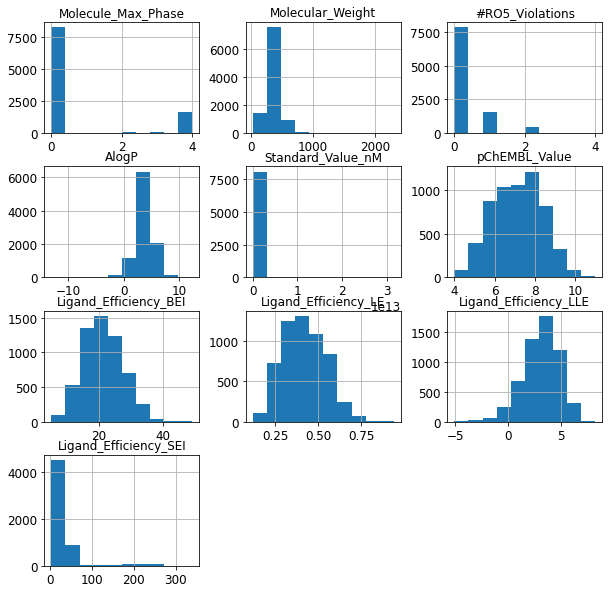

In [41]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types/assays represented in the value columns. Let's split those up:**

Standard_Type,% Ctrl,% Inhibition of Control Specific Binding (Mean n=2),Activity,Bmax,Discrimination ratio,Displacement,EC50,ED50,Efficacy,FC,IC5,IC50,INH,Inhibition,Kd,Ki,Kinact,RFU,Ratio,Ratio IC50,Ratio Ki,T1/2,pKD
count,7.000000,8.000000,93.000000,1.0,1.0,2.0,8.700000e+01,20.000000,5.000000,42.000000,10.000000,2.920000e+03,11.000000,715.000000,22.000000,2.565000e+03,1.00,8.000000,84.000000,9.000000,3.000000,28.000000,52.000000
mean,96.785714,2.575000,1522.857312,1.3,1.8,100.0,1.932074e+11,6.641500,24.640000,20.717524,5285.100000,5.704570e+03,26927.272727,36.776040,1010.139545,4.718105e+04,2.26,0.944125,16.043175,6.055556,34.666667,0.652118,6.420769
std,16.263090,6.565222,3136.903722,NaN,NaN,0.0,1.697288e+12,4.119443,31.876135,49.289657,4250.377145,9.454167e+04,35635.630790,30.622597,3699.826586,4.735285e+05,NaN,0.220497,33.762421,1.911224,35.104606,0.311880,0.400156
min,66.000000,-7.700000,-45.000000,1.3,1.8,100.0,2.700000e+00,0.500000,3.400000,0.080000,48.000000,0.000000e+00,-3000.000000,-44.000000,0.130000,0.000000e+00,2.26,0.424000,0.060000,2.000000,11.000000,0.190000,5.540000
25%,94.000000,-2.225000,8.000000,1.3,1.8,100.0,8.200000e+03,2.150000,8.800000,0.565000,860.750000,1.900000e+01,-1000.000000,10.000000,3.347500,7.700000e+00,2.26,0.942167,0.895000,7.000000,14.500000,0.380825,6.152500
50%,100.000000,2.800000,35.000000,1.3,1.8,100.0,2.960000e+04,10.000000,15.000000,0.946500,5759.000000,1.584900e+02,12200.000000,38.000000,8.900000,7.200000e+01,2.26,1.033667,2.000000,7.000000,18.000000,0.678350,6.515000
75%,102.250000,7.375000,617.000000,1.3,1.8,100.0,1.648025e+05,10.000000,15.000000,1.064000,9579.000000,1.509125e+03,41000.000000,55.000000,107.500000,1.009000e+03,2.26,1.048667,11.338750,7.000000,46.500000,0.867950,6.702500
max,119.000000,11.700000,10000.000000,1.3,1.8,100.0,1.581139e+13,10.000000,81.000000,140.000000,10000.000000,5.004900e+06,90000.000000,216.500000,17300.000000,1.000000e+07,2.26,1.109000,180.500000,7.000000,75.000000,1.550000,7.230000


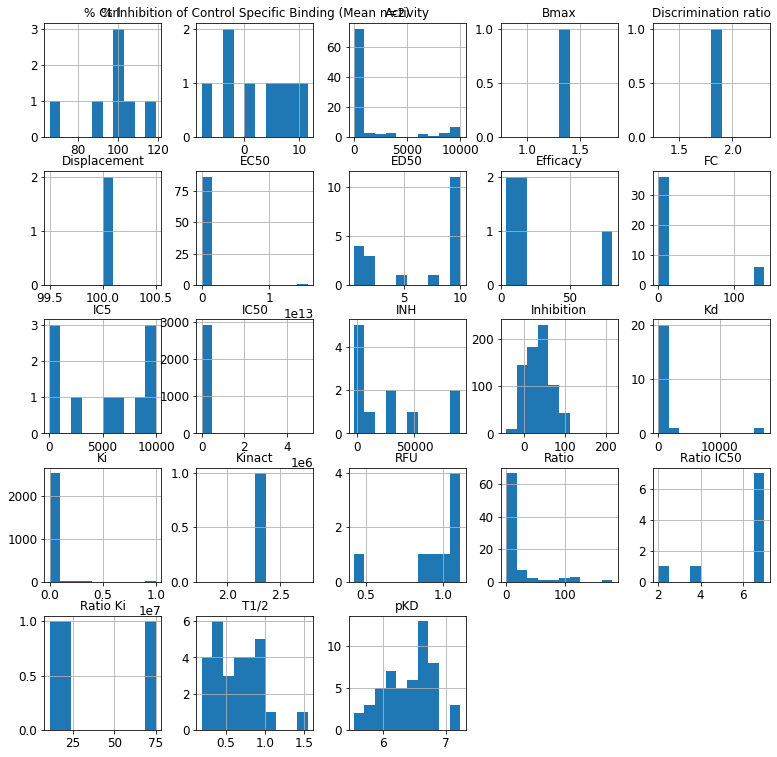

In [42]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

 What do you notice about the standard values?

Standard_Type,EC50,IC50,Kd,Ki
count,70.000000,2564.000000,22.000000,2269.000000
mean,5.060381,6.931353,7.708409,7.340491
std,0.759410,1.089182,1.281340,1.222376
min,4.020000,4.000000,4.760000,4.140000
25%,4.582500,6.060000,6.977500,6.410000
50%,4.761667,7.000000,8.050000,7.400000
75%,5.407500,7.820000,8.505000,8.260000
max,8.570000,10.640000,9.890000,11.000000


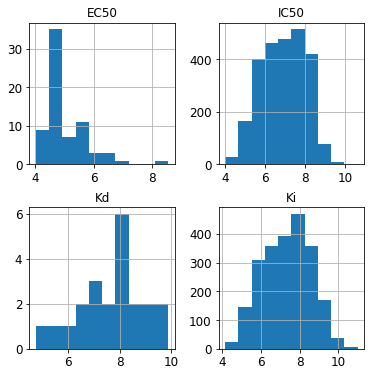

In [43]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

## Exercise: explore DTC and Excape data the same way
- **Curation step:** add pValue column from raw measurements if it doesn't exist

In [ ]:
# try it yourself here

In [44]:
dtc.iloc[0:3, 0:5]

,compound_id,standard_inchi_key,compound_name,synonym,target_id
0,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,NaN,NaN,P31645
1,CHEMBL336100,AAADQEFQWNJHOZ-UHFFFAOYSA-N,NaN,NaN,P31645
2,CHEMBL14144,AAEKULYONKUBOZ-UHFFFAOYSA-N,NaN,NaN,P31645


In [45]:
# transform the response value
# DTC ['NM' nan '%' 'UG.ML-1']
dtc['pDTC_Value'] = np.where(dtc.standard_units == 'NM',
                                           -np.log10(dtc.standard_value/1000000000),
                                           dtc.standard_value)

standard_type,ACTIVITY,Activity,BMAX,DISCRIMINATION RATIO,DISPLACEMENT,EC50,ED50,EFFICACY,FC,IC5,IC50,INH,INHIBITION,Inhibition,KD,KI,KINACT,Ki,PKA,PKD,RATIO,RATIO IC50,RATIO KI,RFU,T1/2
count,88.000000,2.000000,1.0,1.0,2.0,5.400000e+01,20.000000,5.000000,30.000000,10.000000,2.702000e+03,11.000000,480.000000,21.000000,21.000000,2.331000e+03,1.00,78.000000,3.000000,52.000000,80.000000,9.000000,2.000000,8.000000,28.000000
mean,1607.592386,24.300000,1.3,1.8,100.0,5.029789e+05,6.641500,24.640000,28.613000,5285.100000,4.713344e+03,26927.272727,40.947481,59.042857,1048.241429,5.092726e+04,2.26,1743.195325,6.836667,6.420769,16.645333,6.055556,46.500000,0.944792,0.651982
std,3204.772256,36.345289,NaN,NaN,0.0,1.395208e+06,4.119443,31.876135,56.648383,4250.377145,9.697437e+04,35635.630790,30.149802,19.464033,3786.768688,4.957148e+05,NaN,2751.417444,3.087108,0.400156,34.486216,1.911224,40.305087,0.220885,0.311771
min,-45.000000,-1.400000,1.3,1.8,100.0,2.700000e+00,0.500000,3.400000,0.080000,48.000000,0.000000e+00,-3000.000000,-43.900000,30.000000,0.130000,9.500000e-03,2.26,2.200000,4.240000,5.540000,0.060000,2.000000,18.000000,0.424000,0.190000
25%,8.000000,11.450000,1.3,1.8,100.0,7.612145e+03,2.150000,8.800000,0.417500,860.750000,1.800000e+01,-1000.000000,14.600000,50.000000,2.600000,8.000000e+00,2.26,29.603875,5.130000,6.152500,0.847500,7.000000,32.250000,0.942417,0.380750
50%,40.000000,24.300000,1.3,1.8,100.0,7.594991e+04,10.000000,15.000000,0.775000,5759.000000,1.370000e+02,12200.000000,44.000000,50.000000,8.900000,8.100000e+01,2.26,457.783333,6.020000,6.515000,1.900000,7.000000,46.500000,1.034000,0.678500
75%,735.000000,37.150000,1.3,1.8,100.0,2.162253e+05,10.000000,15.000000,2.065000,9579.000000,1.147500e+03,41000.000000,60.625000,70.000000,76.000000,1.051000e+03,2.26,2091.250000,8.135000,6.702500,13.225000,7.000000,60.750000,1.050000,0.868250
max,10000.000000,50.000000,1.3,1.8,100.0,6.227354e+06,10.000000,81.000000,140.000000,10000.000000,5.004900e+06,90000.000000,216.500000,96.500000,17300.000000,1.000000e+07,2.26,10566.666667,10.250000,7.230000,180.500000,7.000000,75.000000,1.110000,1.550000


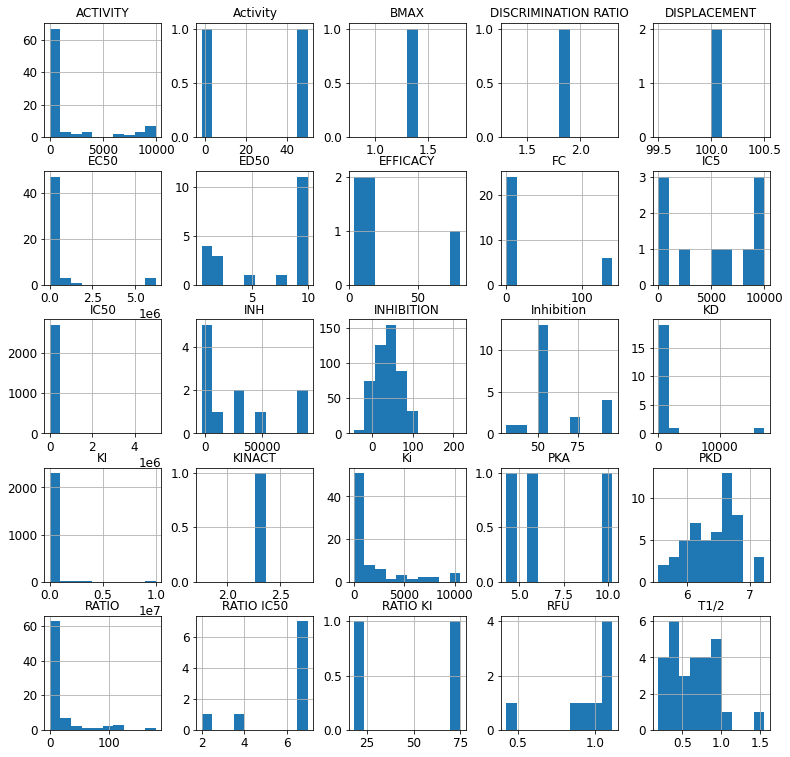

In [46]:

dtc_types=dtc.pivot_table(index = 'compound_id', columns = 'standard_type', values='standard_value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(13,13));

In [47]:

dtc=dtc.replace('None',np.nan)
dtc.columns

Index(['compound_id', 'standard_inchi_key', 'compound_name', 'synonym',
       'target_id', 'target_pref_name', 'gene_names', 'wildtype_or_mutant',
       'mutation_info', 'pubmed_id', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units', 'activity_comment',
       'ep_action_mode', 'assay_format', 'assaytype', 'assay_subtype',
       'inhibitor_type', 'detection_tech', 'assay_cell_line',
       'compound_concentration_value', 'compound_concentration_value_unit',
       'substrate_type', 'substrate_relation', 'substrate_value',
       'substrate_units', 'assay_description', 'title', 'journal', 'doc_type',
       'annotation_comments', 'pDTC_Value'],
      dtype='object')

standard_type,ACTIVITY,Activity,BMAX,DISCRIMINATION RATIO,DISPLACEMENT,EC50,ED50,EFFICACY,FC,IC5,IC50,INH,INHIBITION,Inhibition,KD,KI,KINACT,Ki,PKA,PKD,RATIO,RATIO IC50,RATIO KI,RFU,T1/2
count,88.000000,2.000000,1.0,1.0,2.0,54.000000,20.000000,5.000000,30.000000,10.000000,2702.000000,6.000000,480.000000,21.000000,21.000000,2331.000000,1.000000,78.000000,3.000000,52.000000,80.000000,9.000000,2.000000,8.000000,28.000000
mean,126.927723,24.300000,1.3,1.8,100.0,4.532602,6.641500,24.640000,28.613000,5.657000,inf,4.382023,40.947481,59.042857,7.756783,7.248696,8.645892,6.636737,6.836667,6.420769,16.645333,6.055556,46.500000,0.944792,0.651982
std,1064.825297,36.345289,NaN,NaN,0.0,1.102664,4.119443,31.876135,56.648383,0.835429,NaN,0.325497,30.149802,19.464033,1.291582,10.380459,NaN,1.027395,3.087108,0.400156,34.486216,1.911224,40.305087,0.220885,0.311771
min,-45.000000,-1.400000,1.3,1.8,100.0,2.305000,0.500000,3.400000,0.080000,5.000000,0.050000,4.045757,-43.900000,30.000000,4.761954,2.000000,8.645892,5.000000,4.240000,5.540000,0.060000,2.000000,18.000000,0.424000,0.190000
25%,5.000000,11.450000,1.3,1.8,100.0,3.931250,2.150000,8.800000,0.417500,5.020021,5.958607,4.117647,14.600000,50.000000,7.119186,5.996788,8.645892,5.857889,5.130000,6.152500,0.847500,7.000000,32.250000,0.942417,0.380750
50%,6.573760,24.300000,1.3,1.8,100.0,4.303750,10.000000,15.000000,0.775000,5.241709,6.886057,4.393640,44.000000,50.000000,8.050610,7.124939,8.645892,6.511865,6.020000,6.515000,1.900000,7.000000,46.500000,1.034000,0.678500
75%,12.750000,37.150000,1.3,1.8,100.0,5.172500,10.000000,15.000000,2.065000,6.240946,7.769551,4.488268,60.625000,70.000000,8.585027,8.117391,8.645892,7.558181,8.135000,6.702500,13.225000,7.000000,60.750000,1.050000,0.868250
max,10000.000000,50.000000,1.3,1.8,100.0,8.568636,10.000000,81.000000,140.000000,7.318759,inf,4.913640,216.500000,96.500000,9.886057,503.150515,8.645892,8.657577,10.250000,7.230000,180.500000,7.000000,75.000000,1.110000,1.550000


ValueError: ignored

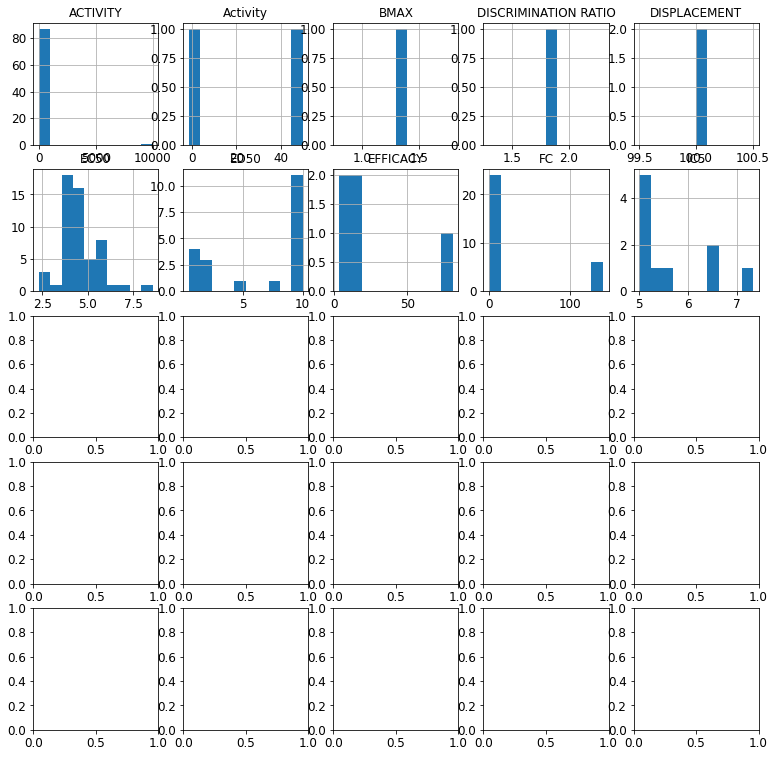

In [49]:
dtc_types=dtc.pivot_table(index = 'compound_id', columns = 'standard_type', values='pDTC_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(13,13));

,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID,Ortholog_Group
count,7610.000000,7597.000000,7.610000e+03,7610.000000,7610.0
mean,15417.631406,7.068187,4.358954e+05,9844.245729,4061.0
std,9490.573500,1.309573,2.455972e+05,254.465721,0.0
min,6532.000000,2.040000,2.710000e+02,9606.000000,4061.0
25%,6532.000000,6.110140,2.019930e+05,9606.000000,4061.0
50%,6532.000000,7.070000,3.887030e+05,9606.000000,4061.0
75%,25553.000000,8.040000,5.925250e+05,10116.000000,4061.0
max,25553.000000,11.700000,1.367806e+06,10116.000000,4061.0


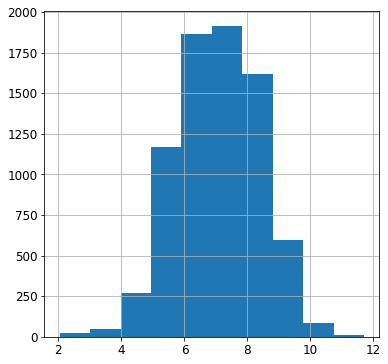

In [50]:

display(excape.describe())
excape.pXC50.hist(figsize=(6,6))

## EDA & Exercise: compare pResponse values across all three datasets
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

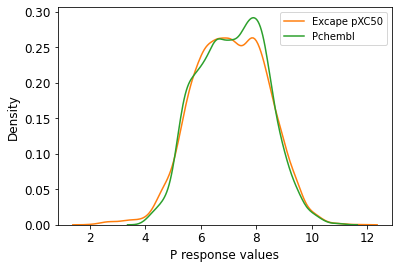

In [51]:

import matplotlib.pyplot as plt
import seaborn as sns
pdtc50 = dtc.loc[(dtc['standard_type'] == 'IC50') | (dtc['standard_type'] =='EC50'),"pDTC_Value"]
sns.kdeplot(pdtc50, label = 'pDTC50')
sns.kdeplot(excape['pXC50'], label='Excape pXC50')
sns.kdeplot(chembl['pChEMBL_Value'], label='Pchembl')
plt.xlabel('P response values')
plt.legend()

## Exercise: analyze & discuss
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

# EDA: Compounds
- make sure smiles strings exist since that's what AMPL uses
- compare compounds in each dataset
- featurize with ECFP fingerprints
- examine diversity of compound set

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets/excel or from the LHS folder menu, right-click on the "HTR3A_DTC.csv" file to download it to your computer and open the file with Excel. 
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi  (use highlight and click on "Follow-link" option to open the link in your browser)
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

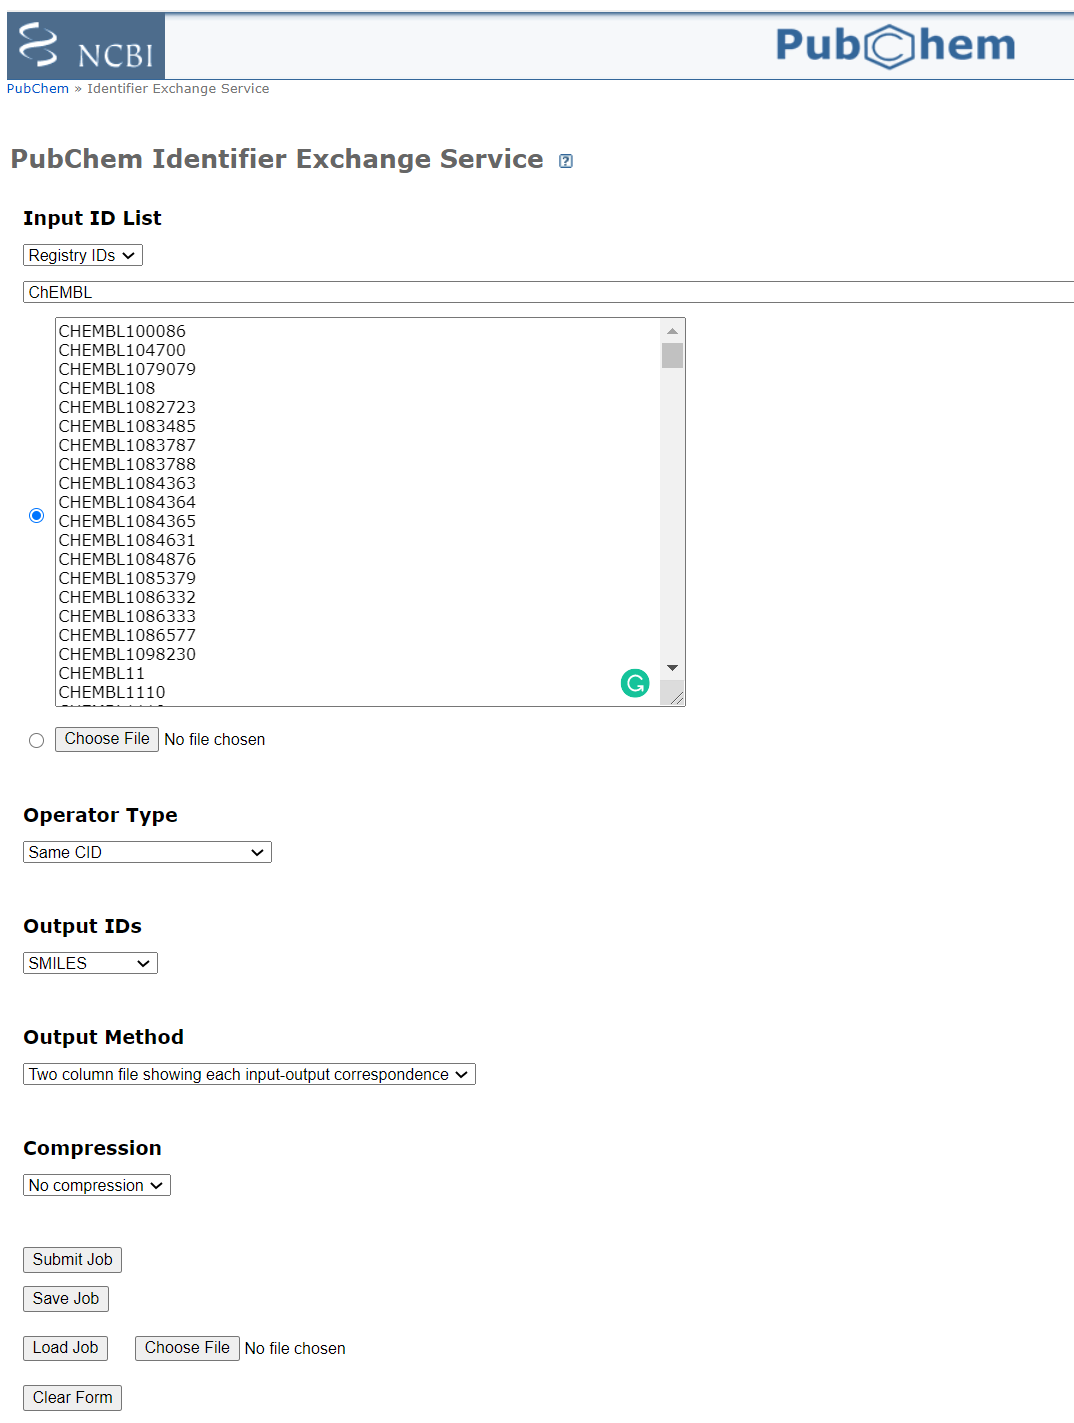

In [ ]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/Img/PubChemCIDExchange.png", 
      width = 900, height = 900)

## Note, the output from PubChem Identifier Exchange Service can be uploaded into the left hand window of COLAB by dragging and dropping the file. In my case the output file is, `3897649727682520004.txt`

In my case, I have saved the file in Github and I am uploading it. 

In [52]:
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/3897649727682520004.txt

--2021-03-19 15:08:26--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/3897649727682520004.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90865 (89K) [text/plain]
Saving to: ‘3897649727682520004.txt’

3897649727682520004 100%[===================>]  88.74K  --.-KB/s    in 0.02s   

2021-03-19 15:08:27 (5.27 MB/s) - ‘3897649727682520004.txt’ saved [90865/90865]



In [53]:
# open file from pubchem ID exchange service
dtc_smiles = pd.read_csv("3897649727682520004.txt", sep="\t", header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL100086,COC1=CC=CC(=C1)CN2CCN(CC2)C3CCC(CC3)(C4=CC5=C(...
1,CHEMBL104700,C1CC2CCC1N2CC3=CN=CC=C3
2,CHEMBL1079079,COC1=CC=C(C=C1)C2=C(C(=NN2C3=CC=CC=C3[125I])C(...
3,CHEMBL108,C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N
4,CHEMBL1082723,C[C@H]1CC2=C([C@]3(N1)C4=C(C=CC(=C4)Cl)NC3=O)N...


In [54]:
dtc_smiles['ChEMBL_ID']

0        CHEMBL100086
1        CHEMBL104700
2       CHEMBL1079079
3           CHEMBL108
4       CHEMBL1082723
            ...      
1276      CHEMBL93919
1277         CHEMBL96
1278      CHEMBL98883
1279      CHEMBL98883
1280      CHEMBL98883
Name: ChEMBL_ID, Length: 1281, dtype: object

In [56]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['compound_id'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [58]:
# what's missing?
print("No ChemblID in DTC:", len(dtc[dtc['compound_id'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 15
No SMILES from ChemblID in DTC: 8742


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [ ]:
# try it yourself here

## EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

In [59]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2

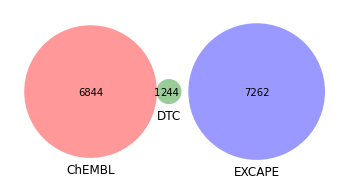

In [60]:
# overlaps from SMILES strings
venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists

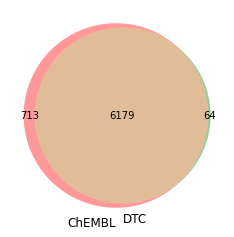

In [61]:
venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.compound_id)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

## **Curation step:** Standardize smiles strings, drop rows without base smiles

In [62]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

10078
6845
6758


In [63]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
285,CHEMBL136478,SODIUM NITROPRUSSIDE,4.0,261.92,NaN,NaN,SODIUM NITROPRUSSIDE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909109,"DRUGMATRIX: Transporter, Serotonin (5-Hydroxyt...",B,BAO_0000249,cell membrane format,NaN,NaN,NaN,HEK293,Membrane,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN,NaN,
456,CHEMBL118075,O-863,0.0,747.78,NaN,NaN,26b (O-1196),NaN,IC50,'=',639.0,nM,6.19,NaN,NaN,UO_0000065,8.28,NaN,NaN,NaN,False,CHEMBL806185,In vitro affinity for serotonin transporter in...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,639.0,
474,CHEMBL332491,O-1339,0.0,728.95,NaN,NaN,27c (O-1339),NaN,IC50,'=',58.9,nM,7.23,NaN,NaN,UO_0000065,9.92,NaN,NaN,NaN,False,CHEMBL806185,In vitro affinity for serotonin transporter in...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,58.9,
665,CHEMBL1909067,NaN,0.0,NaN,NaN,NaN,MC 258714,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909109,"DRUGMATRIX: Transporter, Serotonin (5-Hydroxyt...",B,BAO_0000249,cell membrane format,NaN,NaN,NaN,HEK293,Membrane,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN,NaN,
683,CHEMBL118075,O-863,0.0,747.78,NaN,NaN,27b (O-863),NaN,IC50,'=',264.0,nM,6.58,NaN,NaN,UO_0000065,8.80,NaN,NaN,NaN,False,CHEMBL806185,In vitro affinity for serotonin transporter in...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,264.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9259,CHEMBL326165,N-[(2-((3'-N-propyl-(1''R) -3''beta-(4-fluorop...,0.0,694.91,NaN,NaN,13a (O-1508),NaN,IC50,'=',200.0,nM,6.70,NaN,NaN,UO_0000065,9.64,NaN,NaN,NaN,False,CHEMBL806185,In vitro affinity for serotonin transporter in...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,200.0,
9472,CHEMBL1909074,POLYVINYLPYRROLIDONE,0.0,NaN,NaN,NaN,POLYVINYLPYRROLIDONE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909109,"DRUGMATRIX: Transporter, Serotonin (5-Hydroxyt...",B,BAO_0000249,cell membrane format,NaN,NaN,NaN,HEK293,Membrane,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN,NaN,
9544,CHEMBL1909068,NaN,0.0,NaN,NaN,NaN,MC 258717,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50

In [64]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
285,CHEMBL136478,SODIUM NITROPRUSSIDE,4.0,261.92,NaN,NaN,SODIUM NITROPRUSSIDE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909109,"DRUGMATRIX: Transporter, Serotonin (5-Hydroxyt...",B,BAO_0000249,cell membrane format,NaN,NaN,NaN,HEK293,Membrane,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN,NaN,NaN
456,CHEMBL118075,O-863,0.0,747.78,NaN,NaN,26b (O-1196),NaN,IC50,'=',639.0,nM,6.19,NaN,NaN,UO_0000065,8.28,NaN,NaN,NaN,False,CHEMBL806185,In vitro affinity for serotonin transporter in...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,639.0,NaN
474,CHEMBL332491,O-1339,0.0,728.95,NaN,NaN,27c (O-1339),NaN,IC50,'=',58.9,nM,7.23,NaN,NaN,UO_0000065,9.92,NaN,NaN,NaN,False,CHEMBL806185,In vitro affinity for serotonin transporter in...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,58.9,NaN
665,CHEMBL1909067,NaN,0.0,NaN,NaN,NaN,MC 258714,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909109,"DRUGMATRIX: Transporter, Serotonin (5-Hydroxyt...",B,BAO_0000249,cell membrane format,NaN,NaN,NaN,HEK293,Membrane,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN,NaN,NaN
683,CHEMBL118075,O-863,0.0,747.78,NaN,NaN,27b (O-863),NaN,IC50,'=',264.0,nM,6.58,NaN,NaN,UO_0000065,8.80,NaN,NaN,NaN,False,CHEMBL806185,In vitro affinity for serotonin transporter in...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,264.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9259,CHEMBL326165,N-[(2-((3'-N-propyl-(1''R) -3''beta-(4-fluorop...,0.0,694.91,NaN,NaN,13a (O-1508),NaN,IC50,'=',200.0,nM,6.70,NaN,NaN,UO_0000065,9.64,NaN,NaN,NaN,False,CHEMBL806185,In vitro affinity for serotonin transporter in...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,200.0,NaN
9472,CHEMBL1909074,POLYVINYLPYRROLIDONE,0.0,NaN,NaN,NaN,POLYVINYLPYRROLIDONE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909109,"DRUGMATRIX: Transporter, Serotonin (5-Hydroxyt...",B,BAO_0000249,cell membrane format,NaN,NaN,NaN,HEK293,Membrane,NaN,NaN,NaN,CHEMBL228,Serotonin transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN,NaN,NaN
9544,CHEMBL1909068,NaN,0.0,NaN,NaN,NaN,MC 258717,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Ac

In [65]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

## Exercise: standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

## **Curation step:** Save standardized datasets

In [ ]:
chembl.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL_SMILES.csv")
dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_DTC_SMILES.csv")
excape.to_csv("/content/drive/MyDrive/Columbia_E4511/HTR3A_Excape_SMILES.csv")

## Exercise: examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

## EDA: Examine compound diversity

In [ ]:
import diversity_plots as dp
sns.set_context('poster')

In [ ]:
dp.plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL_SMILES.csv', 
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value')

## Exercise: create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

## Exercise: analyze and discuss these plots.
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
  - what radius and vector length are used in these functions?
  - hint: look at the .py files for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?